In [142]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [172]:
aligned = cv2.imread('edge.jpeg')
misaligned = cv2.imread('edge-misaligned.jpeg')

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

aligned_gray = cv2.cvtColor(aligned, cv2.COLOR_RGB2GRAY)
misaligned_gray = cv2.cvtColor(misaligned, cv2.COLOR_RGB2GRAY)

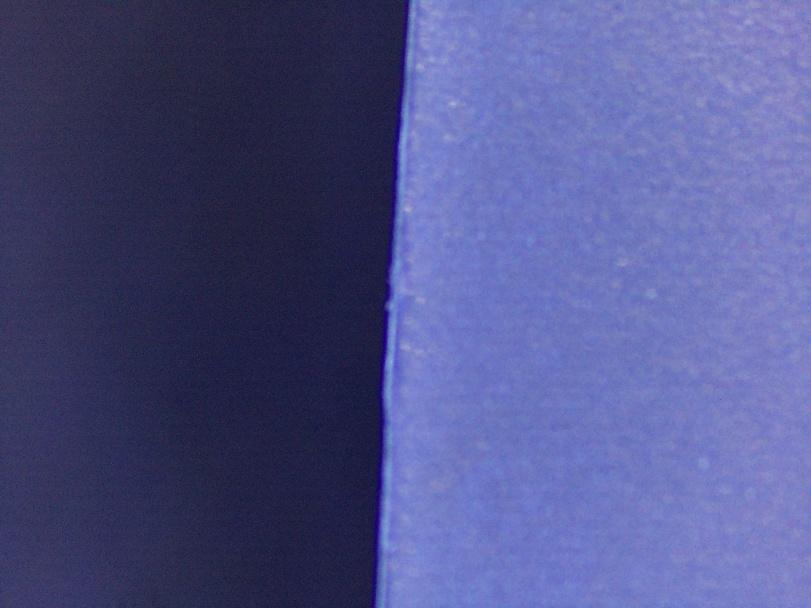

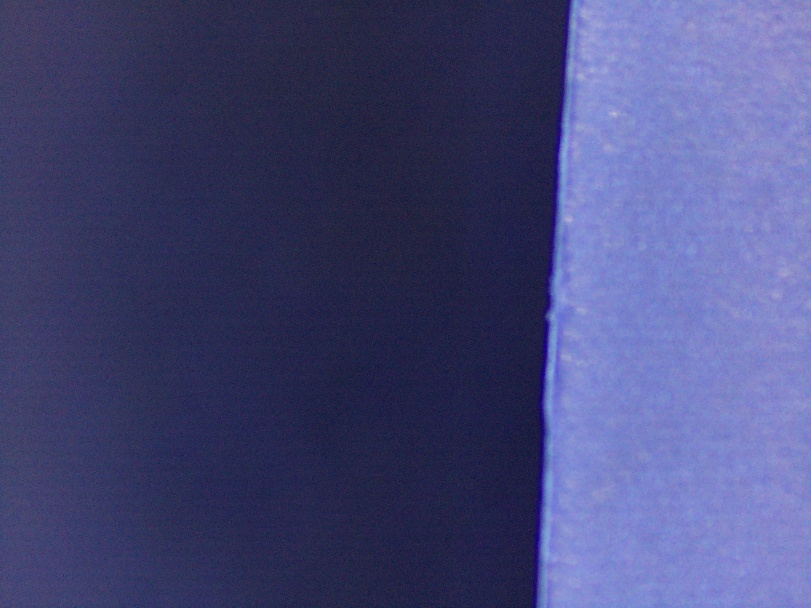

In [144]:
imshow(aligned)
imshow(misaligned)

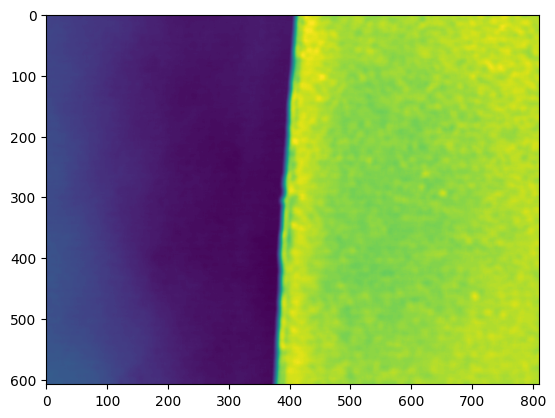

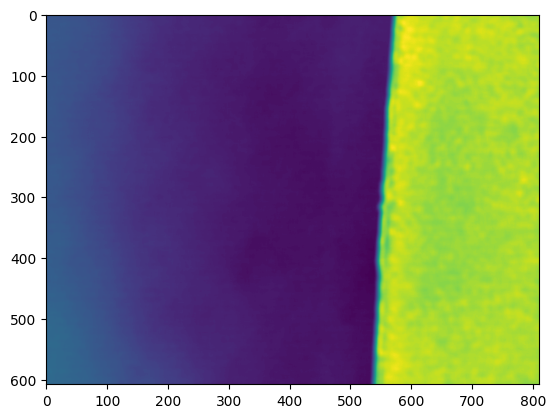

In [145]:
aligned_g = cv2.blur(aligned_gray, (10, 10))
misaligned_g = cv2.blur(misaligned_gray, (10, 10))
plt.figure(1)
plt.imshow(aligned_g)
plt.figure(2)
plt.imshow(misaligned_g)

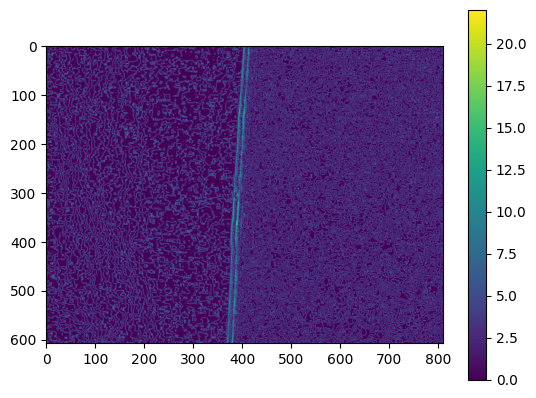

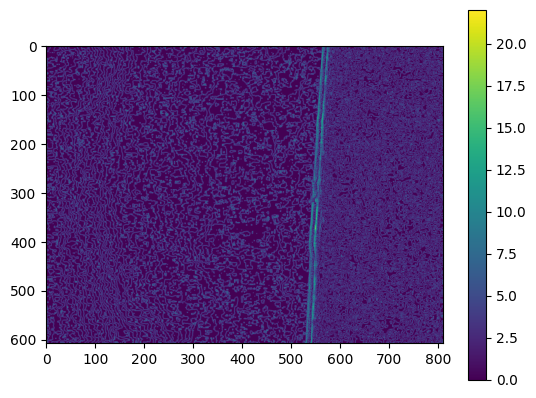

In [146]:
aligned_l_s = cv2.Laplacian(aligned_g, cv2.CV_16S, ksize=3)
misaligned_l_s = cv2.Laplacian(misaligned_g, cv2.CV_16S, ksize=3)

aligned_l = cv2.convertScaleAbs(aligned_l_s)
misaligned_l = cv2.convertScaleAbs(misaligned_l_s)

plt.figure(1)
plt.imshow(aligned_l)
plt.colorbar()
plt.figure(2)
plt.imshow(misaligned_l)
plt.colorbar()

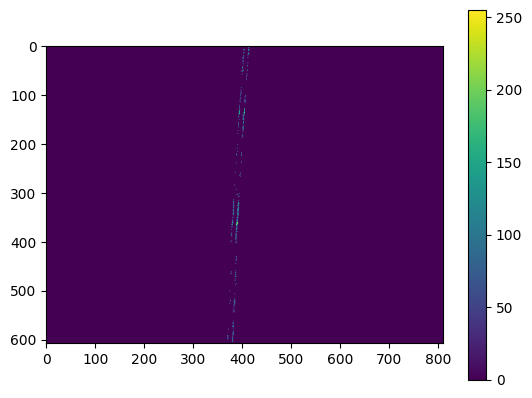

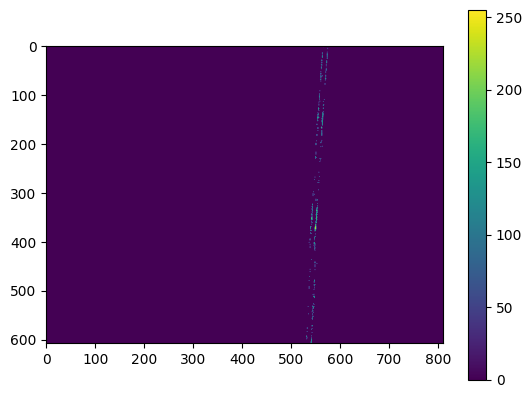

In [147]:
ret, aligned_t = cv2.threshold(aligned_l, 12, 255, cv2.THRESH_BINARY)
ret, misaligned_t = cv2.threshold(misaligned_l, 12, 255, cv2.THRESH_BINARY)

plt.figure(1)
plt.imshow(aligned_t)
plt.colorbar()
plt.figure(2)
plt.imshow(misaligned_t)
plt.colorbar()

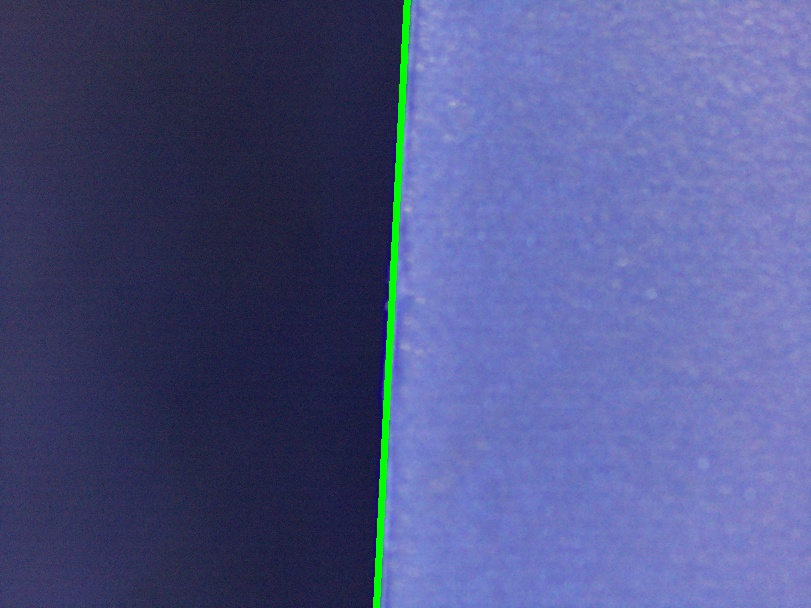

In [148]:
aligned_points = cv2.findNonZero(aligned_t)
a_vx, a_vy, a_cx, a_cy = cv2.fitLine(aligned_points, cv2.DIST_L2, 0, 0.01, 0.01)

h, w, _ = aligned.shape

aligned_line = aligned.copy()
cv2.line(aligned_line, (int(a_cx-a_vx*w), int(a_cy-a_vy*w)), (int(a_cx+a_vx*w), int(a_cy+a_vy*w)), (0, 255, 0), 5)

imshow(aligned_line)

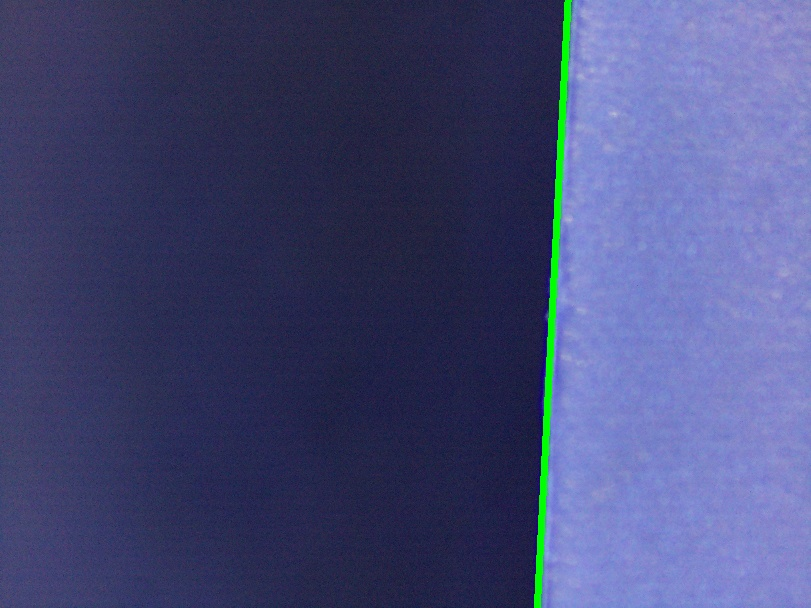

In [149]:
misaligned_points = cv2.findNonZero(misaligned_t)
m_vx, m_vy, m_cx, m_cy = cv2.fitLine(np.float32(misaligned_points), cv2.DIST_L2, 0, 0.001, 0.001)

h, w, _ = misaligned.shape

misaligned_line = misaligned.copy()
cv2.line(misaligned_line, (int(m_cx-m_vx*w), int(m_cy-m_vy*w)), (int(m_cx+m_vx*w), int(m_cy+m_vy*w)), (0, 255, 0), 5)

imshow(misaligned_line)

In [163]:
def build_r(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

def compute_error(img, vx, vy, cx, cy):
    v = np.array([vx[0], vy[0]])
    p = np.array([cx[0], cy[0]])

    # rotate fit to y axis
    theta = np.arccos(np.dot([0, 1], v) / np.linalg.norm(v))

    R = cv2.getRotationMatrix2D(p, -57.2958 * theta, 1.0)
    rot_img = cv2.warpAffine(img, R, aligned.shape[1::-1], flags=cv2.INTER_LINEAR)

    points = cv2.findNonZero(rot_img).squeeze(1)

    err = (points - p)[:,0]**2
    return np.sqrt(np.einsum('i,i->',err,err) / len(points)), theta

print(a_vx, a_vy, a_cx, a_cy)
print(m_vx, m_vy, m_cx, m_cy)

err_g, theta_g = compute_error(aligned_t, a_vx, a_vy, a_cx, a_cy)
err_b, theta_b = compute_error(misaligned_t, m_vx, m_vy, m_cx, m_cy)
print("good", err_g, theta_g)
print("bad", err_b, theta_b)

[0.05047579] [-0.9987253] [392.27414] [290.70758]
[0.05021672] [-0.99873835] [553.2769] [287.48572]
good 32.31302749079228 3.091095607391621
bad 33.58710660615876 3.0913548809611457


[392.27414]


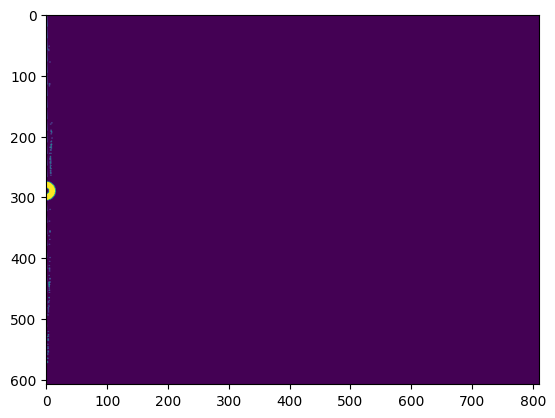

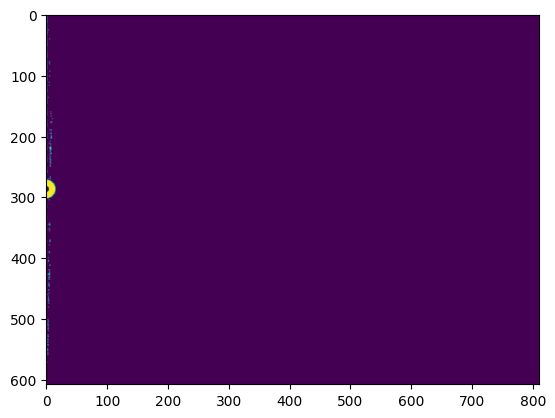

In [164]:
def rad_to_deg(rad):
    return 57.2958 * rad

print(a_cx)

t_a = np.float32([ [1,0,-a_cx[0]], [0,1,0] ])
t_m = np.float32([ [1,0,-m_cx[0]], [0,1,0] ])

image_center = (w//2, h//2)
aligned_r = aligned_t.copy()
cv2.line(aligned_r, (int(a_cx-a_vx*w), int(a_cy-a_vy*w)), (int(a_cx+a_vx*w), int(a_cy+a_vy*w)), (255, 255, 255), 1)
cv2.circle(aligned_r, [int(a_cx[0]), int(a_cy[0])], 10, 255, 10)
aligned_r = cv2.warpAffine(aligned_r, cv2.getRotationMatrix2D((int(a_cx[0]), int(a_cy[0])), -rad_to_deg(theta_g), 1.0), aligned.shape[1::-1], flags=cv2.INTER_LINEAR)
aligned_r = cv2.warpAffine(aligned_r, t_a, aligned.shape[1::-1], flags=cv2.INTER_LINEAR)

misaligned_r = misaligned_t.copy()
cv2.line(misaligned_r, (int(m_cx-m_vx*w), int(m_cy-m_vy*w)), (int(m_cx+m_vx*w), int(m_cy+m_vy*w)), (255, 255, 255), 1)
cv2.circle(misaligned_r, [int(m_cx[0]), int(m_cy[0])], 10, 255, 10)
misaligned_r = cv2.warpAffine(misaligned_r, cv2.getRotationMatrix2D((int(m_cx[0]), int(m_cy[0])), -rad_to_deg(theta_b), 1.0), aligned.shape[1::-1], flags=cv2.INTER_LINEAR)
misaligned_r = cv2.warpAffine(misaligned_r, t_m, aligned.shape[1::-1], flags=cv2.INTER_LINEAR)

plt.figure(1)
plt.imshow(aligned_r)
plt.figure(2)
plt.imshow(misaligned_r)

In [152]:
print(a_cx)

[392.27414]


In [166]:
a_s = np.linalg.solve([
    [a_vx[0], -1],
    [a_vy[0], 0]
], [ -a_cx[0], (h/2) - a_cy[0] ])

m_s = np.linalg.solve([
    [m_vx[0], -1],
    [m_vy[0], 0]
], [ -m_cx[0], (h/2) - m_cy[0] ])

In [168]:
a_p = [int(a_s[1]), h//2]
m_p = [int(m_s[1]), h//2]

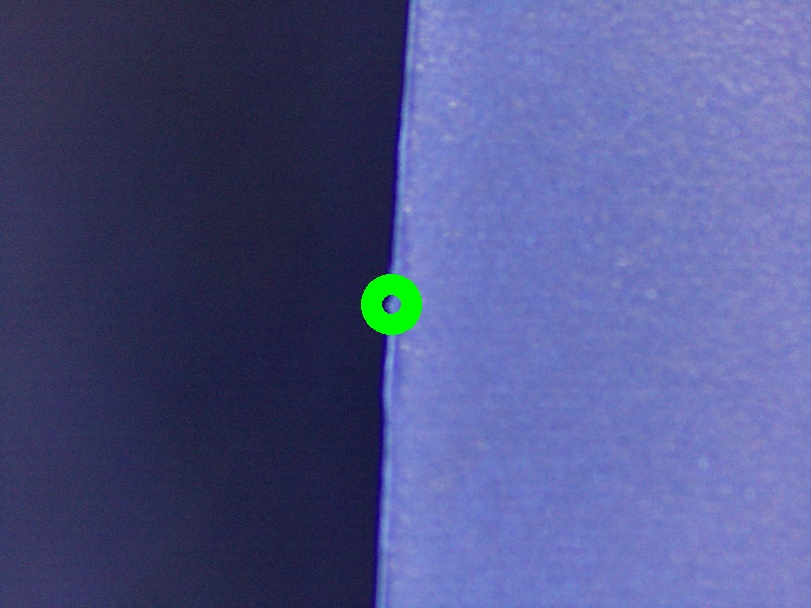

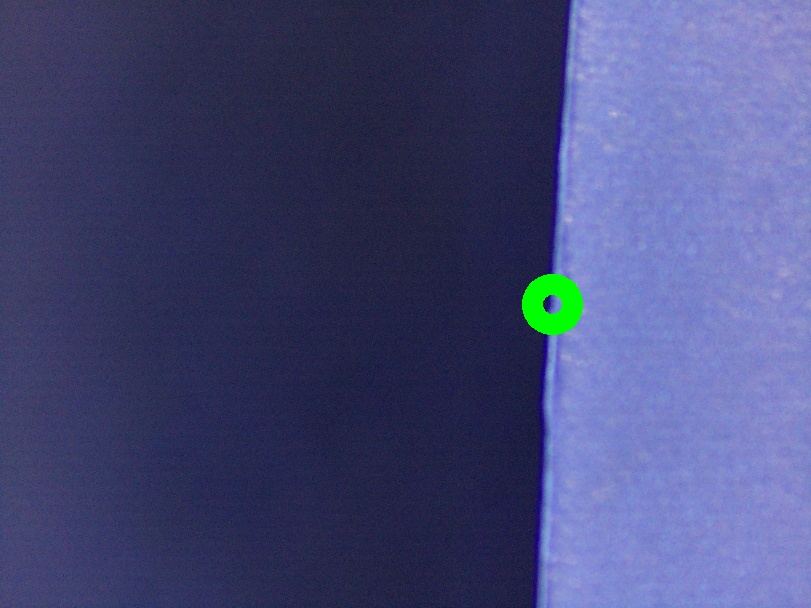

In [174]:
aligned_with_dot = cv2.circle(aligned.copy(), a_p, 20, (0, 255, 0), 20)
imshow(aligned_with_dot)
misaligned_with_dot = cv2.circle(misaligned.copy(), m_p, 20, (0, 255, 0), 20)
imshow(misaligned_with_dot)

In [156]:
abs(0.5 - 0.4832004015427384)
IM_WIDTH_PER_EIGHTH_STEP = 0.0010059171597633137
edge_position = solution[1] / w
(edge_position - 0.5) / IM_WIDTH_PER_EIGHTH_STEP

-17.03564904599233

In [181]:
def compute_error(img: np.ndarray, vx: float, vy: float, cx: float, cy: float):
    """
    Compute the standard deviation of the point errors given
    a line of best fit
    :param points: Points to compute standard deviation for
    :param vx: Delta X of regression.
    :param vy: Delta Y of regression.
    :param cx: Start X point of regression
    :param cy: Start Y point of regression
    :return: Standard deviation in pixels
    """
    v = np.array([vx, vy])
    p = np.array([cx, cy])

    # Find the rotation to align to Y-axis
    # This will make the error between point-to-linear-regression
    # the same as the X-coordinate
    theta = np.arccos(np.dot(v, [0, 1]) / np.linalg.norm(v))

    # Construct a rotation matrix
    r = cv2.getRotationMatrix2D(p, -180 / np.pi * theta, 1.0)
    rot_img = cv2.warpAffine(img, r, img.shape[0:2], flags=cv2.INTER_LINEAR)

    # Compute the error using only the X coordinate
    # This will be the norm distance of each point to the line
    points = cv2.findNonZero(rot_img).squeeze(1)
    err = (points - p)[:,0]**2

    # Compute the standard deviation
    return np.sqrt(np.einsum('i,i->', err, err) / len(points)), theta


def detect_card_edge(img: np.ndarray,
                     laplacian_threshold: float = 10.0,
                     standard_deviation_threshold: float = 50.0,
                     vertical_rad_threshold: float = 0.1,
                     debug: bool = False):
    """
    Find the line of best fit for the derivative of an image
    This is essentially like applying a linear regression to
    edges in an image.
    :param img: Image to find best fit for
    :param laplacian_threshold: Threshold of edge to use in regression
    :param standard_deviation_threshold: Threshold for linear regression standard deviation
    :param vertical_rad_threshold: Threshold for how vertical the edge of the card should be
    :param debug: Print debug messages
    :return: None if card edge is not in image (a good, relatively vertical line was not found),
             Float from 0.0 - 1.0 indicating where the edge of the card on the image frame
            (0 means left side of the image, 1 means right side)
    """
    # Compress the data to a manageable size
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (608, 810))

    h, w = img.shape

    # Blur the image using a 10x10 averaging kernel
    # Gets rid of gradient noise
    img = cv2.blur(img, (10, 10))

    # Use a laplacian kernel to compute the Gxy gradient
    # across the image to detect edges.
    # We are looking for the edge of the card
    img = cv2.Laplacian(img, cv2.CV_16S, ksize=3)

    # Get image back into 8-bit grayscale
    img = cv2.convertScaleAbs(img)

    # Select the best points
    _, img = cv2.threshold(img, laplacian_threshold, 255, cv2.THRESH_BINARY)

    # Gather a list of potential points on the edge of the sensor card
    points = cv2.findNonZero(img)
    if points is None:
        print("No edges")
        return None

    # Perform an L2 norm linear regression to get the line of
    # best fit along the threshold edge
    vx_r, vy_r, cx_r, cy_r = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
    vx, vy, cx, cy = vx_r[0], vy_r[0], cx_r[0], cy_r[0]

    err, theta = compute_error(img, vx, vy, cx, cy)

    # This is not an actual edge
    # We just fit some garbage
    if err > standard_deviation_threshold:
        print("Std dev", err)
        return None

    # The line is not vertical enough
    # There are some edges in the image, but they are unlikely
    # to be the card edge since that will be vertical with respect to the
    # HQ Camera
    if abs(theta) > vertical_rad_threshold and abs(theta - np.pi) > vertical_rad_threshold:
        print("theta", theta)
        return None

    # Solve for center of the parametric line
    # Solve a simple system of equations
    # (vx, vy) * t + (cx, cy) = (1, 0) * s + (0, h / 2)
    center_ts = np.linalg.solve([
        [vx, -1],
        [vy, 0]
    ], [-cx, (h / 2) - cy])

    # Plug in the second parametric parameter into the original parametric equation
    # This will yield the center point along X axis
    # Scale this solution to the width
    return center_ts[1] / w


In [182]:
edge = detect_card_edge(cv2.imread("edge.jpeg"))
print(edge)

misaligned = detect_card_edge(cv2.imread("edge-misaligned.jpeg"))
print(misaligned)

no_edge = detect_card_edge(cv2.imread("non-edge.jpeg"))
print(no_edge)

no_edge = detect_card_edge(cv2.imread("pic1.jpeg"))
print(no_edge)

no_edge = detect_card_edge(cv2.imread("pic2.jpeg"))
print(no_edge)

no_edge = detect_card_edge(cv2.imread("tmp/0c635b31-8115-45e7-8996-e1c3f4734ecb.jpg"))
print(no_edge)

0.48171476049141154
0.6798043501983045
Std dev 16256.978689894444
None
Std dev 64155.76074517632
None
Std dev 13040.99589769599
None
Std dev 16504.55707953812
None
